In [13]:
# ! pip install pandas numpy matplotlib seaborn

In [14]:
from typing import Dict, List, Union, TypedDict
from collections import namedtuple
from enum import Enum
from copy import deepcopy

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

EXPDIRNAME = "/home/cc/LSMQueryDrivenCompaction/.vstats/experiments-heatmaps3-E16-B64-S9000-Y0.1-T5"

In [15]:
NUMEPOCHS = 1

INSERTS = 4_500_000
UPDATES = 1_125_000
RANGE_QUERIES = 9000
SELECTIVITY = 0.1
SIZE_RATIO = 5
ENTRY_SIZE = 16  # E
ENTRIES_PER_PAGE = 64  # B
NUM_PAGE_PER_FILE = 64  # P

# _LB_MULTIPLIER = 0.25
# _UB_MULTIPLIER = 0.5

# NUM_X_POINTS = 8
# NUM_Y_POINTS = 5

# def get_bounds(lowest, highest, num_points):
#     points = list()

#     def find_midpoints(start, end, point):
#         if point == 1:
#             return [start, end]
#         midpoint = (start + end) / 2
#         left_point = point // 2
#         right_point = point - left_point
#         points.append(midpoint)
#         find_midpoints(start, midpoint, left_point)
#         find_midpoints(midpoint, end, right_point)
    
#     find_midpoints(lowest, highest, num_points)
#     return sorted(points) + [highest]

# lower_bounds = get_bounds(0, SIZE_RATIO*_LB_MULTIPLIER, NUM_X_POINTS)
# upper_bounds = get_bounds(0, _UB_MULTIPLIER*SIZE_RATIO, NUM_Y_POINTS)

xx = SIZE_RATIO - 1
bounds = sorted([SIZE_RATIO/(2**x) for x in range(xx-3, xx+4)])

lower_upper_bounds = list()

for lb in bounds:
    for ub in bounds:
        if lb < ub:
            lower_upper_bounds.append((lb, ub))

In [16]:
def vanilla_dirname(comp: Dict[str, Union[int, float]]) -> str:
    return (
        f"I {comp['inserts']} U {comp['updates']} S {comp['range']} Y {comp['selectivity']} "
        f"T {comp['sizeRatio']} rq 0 re 0 E {comp['entrySize']} B {comp['entriesPerPage']}"
    )

def rqdc_dirname(comp: Dict[str, Union[int, float]]) -> str:
    return (
        f"I {comp['inserts']} U {comp['updates']} S {comp['range']} Y {comp['selectivity']} "
        f"T {comp['sizeRatio']} rq 1 re 0 E {comp['entrySize']} B {comp['entriesPerPage']} "
        f"lb {comp['lowerBound']} ub {comp['upperBound']}"
    )

In [17]:
PlottingStats = namedtuple(
    "PlottingStats",
    [
        "CompactionDebt",
        "WriteAmpDebt",
        "WriteAmpDebtFull",
        "WriteAmpDebtPartial",
        "AvgEntriesPerFile",
        "FilesCount",
        "DBSize",
        "ValidEntriesCount",
        "InvalidEntriesCount",
        "TotalWriteBytes",
        "CompactionReadBytes",
    ],
)

class RQColumn(Enum):
    RQ_NUMBER="RQ Number",
    RQ_TOTAL_TIME="RQ Total Time",
    DATA_USEFUL_BYTES_WRITTEN="Data uBytes Written Back",
    TOTAL_USEFUL_BYTES_WRITTN="Total uBytes Written Back",
    USEFUL_ENTRIES_COUNT_WRITTEN="uEntries Count Written Back",
    TOTAL_ENTRIES_READ="Total Entries Read",
    DATA_UNUSEFUL_BYTES_WRITTEN="Data unBytes Written Back",
    TOTAL_UNUSEFUL_BYTES_WRITTEN="Total unBytes Written Back",
    UNUSEFUL_ENTRIES_COUNT_WRITTEN="unEntries Count Written Back",
    RQ_REFRESH_TIME="RQ Refresh Time",
    RQ_RESET_TIME="RQ Reset Time",
    RQ_TIME="Actual RQ Time",

    def __str__(self):
        return '%s' % self.value

class HeatMapStat(TypedDict):
    lb: float
    ub: float
    plottingStats: List[PlottingStats]
    rqStats: pd.DataFrame

AdditionalStats = namedtuple(
    'AdditionalStats',
    [
        'min',
        'max',
        'mean',
        'std',
        'p90th',
        'p95th',
        'p99th'
    ]
)

In [18]:
class EpochStats:
    logfilename = 'workload.log'
    rangequery_stats_filename = 'range_queries.csv'

    def _compaction_debt(self, levels: Dict[str, List]) -> int:
        """
        assuming the levels is sorted by level 0, 1, ... L_n
        $ \text{CD} = \sum_{i=1}^{L_{n-1}} \text{Bytes} \left( L_i \right)$
        """
        sum_of_bytes = 0
        last_lvl_index = len(levels) - 1  # 0 indexed levels

        for lvl, data in enumerate(levels):
            if lvl == last_lvl_index or levels[lvl+1]['LevelSize'] == 0:
                break
            sum_of_bytes += data['LevelSize']
        
        return sum_of_bytes

    def _writeamp_debt(self, levels: Dict[str, List]) -> int:
        """
        assuming the levels is sorted by level 0, 1, ... L_n
        $ \text{WA} = \sum_{i=1}^{L_{n-1}} \text{Bytes} \left( L_i \right) \times (L_{n} - i) $
        """
        sum_of_bytes = 0
        last_lvl_index = len(levels) - 1 # 0 indexed levels
        last_non_empty_level_index = last_lvl_index

        for data in levels[::-1]:
            if data['LevelSize'] != 0:
                break
            last_non_empty_level_index -= 1

        for lvl, data in enumerate(levels):
            if lvl == last_non_empty_level_index:
                break
            sum_of_bytes += data['LevelSize'] * (last_non_empty_level_index - lvl)

        return sum_of_bytes

    def _writeampfull_debt(self, levels: Dict[str, List]) -> int:
        """
        assuming the levels is sorted by level 0, 1, ... L_n
        $ \text{WA\textsuperscript{L1}} = \text{Bytes}\left( L_1 \right) \times (L_{n} - 1)$\\
        $ \text{WA\textsuperscript{full}} = \text{WA\textsuperscript{L1}} + \sum_{i=2}^{L_{n}} \text{Bytes} \left( L_i \right) \times (L_{n} - i + 1) $
        """
        sum_of_bytes = 0
        last_lvl_index = len(levels) - 1 # 0 indexed levels
        last_non_empty_level_index = last_lvl_index

        for data in levels[::-1]:
            if data['LevelSize'] != 0:
                break
            last_non_empty_level_index -= 1

        for lvl, data in enumerate(levels):
            if lvl > last_non_empty_level_index:
                break
            if lvl == 0:
                sum_of_bytes += data['LevelSize'] * last_non_empty_level_index
            else:
                sum_of_bytes += data['LevelSize'] * (last_non_empty_level_index - lvl + 1)

        return sum_of_bytes

    def _writeamppartial_debt(self, levels: Dict[str, List], filesize: int) -> int:
        """
        assuming the levels is sorted by level 0, 1, ... L_n
        $ \text{File Size (FS)} = (P \times B)$ 
        $ \text{WA\textsuperscript{partial}} = WA^{partial} + (\sum_{i=2}^{L_{n}} \text{Bytes} \left( L_{i-1} \right)) - FS \times (L_{n} - 1)$        """
        sum_of_bytes = 0
        last_lvl_index = len(levels) - 1 # 0 indexed levels
        last_non_empty_level_index = last_lvl_index

        for data in levels[::-1]:
            if data['LevelSize'] != 0:
                break
            last_non_empty_level_index -= 1
        
        for lvl, data in enumerate(levels):
            if lvl > last_non_empty_level_index:
                break
            if lvl == 0:
                continue
            sum_of_bytes += levels[lvl-1]['LevelSize']

        return self._writeampfull_debt(levels) + (sum_of_bytes - (filesize * last_non_empty_level_index))

    def _total_write_bytes(self, epoch_stats: List[str]):
        write_bytes = 0

        for line in epoch_stats:
            if line.startswith('rocksdb.compact.write.bytes') or line.startswith('rocksdb.flush.write.bytes'):
                write_bytes += int(line.split(':')[1])
        
        return write_bytes

    def _compaction_read_bytes(self, epoch_stats: List[str]):
        read_bytes = 0

        for line in epoch_stats:
            if line.startswith("rocksdb.compact.read.bytes"):
                read_bytes += int(line.split(':')[1])
        
        return read_bytes

    def _read_one_epoch(self):
        with open(self.filepath, 'r') as file:
            epoch_data = list()
            grabbing_data = False

            for line in file:
                line = line.strip()
                if line.startswith("=========="):
                    if grabbing_data:
                        yield epoch_data
                        epoch_data = list()
                        grabbing_data = False
                elif grabbing_data:
                    epoch_data.append(line)
                else:
                    grabbing_data = True
                    epoch_data.append(line)

    def _parse_one_epoch(self, epoch_stats: List[str]) -> Dict[str, List]:
        columnfamilydata = {'Levels': list()}
        sst_files = {}
        i = 0

        while i < len(epoch_stats):
            currentline = epoch_stats[i]
            # Check if the line contains column family data
            if currentline.startswith("Column Family Name"):
                key_val = currentline.split(',')
                columnfamilydata["Column Family Name"] = key_val[0].split(':')[1].strip().strip(',')
                columnfamilydata["Size"] = int(key_val[1].split(':')[1].strip().strip(',').strip(' bytes'))
                columnfamilydata["Files Count"] = int(key_val[2].split(':')[1].strip().strip(','))
                columnfamilydata["Entries Count"] = int(key_val[3].split(':')[1].strip().strip(','))
                columnfamilydata["Invalid Entries Count"] = int(key_val[4].split(':')[1].strip().strip(','))                
            if "Level:" in currentline:
                key_val = currentline.strip().split(',')
                level = int(key_val[0].split(":")[1].strip().strip(','))
                level_size = int(key_val[1].split(':')[1].strip().strip(',').strip(' bytes'))
                level_files_count = int(key_val[2].split(':')[1].strip().strip(','))

                key_val_sst_files = epoch_stats[i+1].split('],')[:-1]
                sst_files = []
                
                for sst_file_string in key_val_sst_files:
                    # Extract SST file details
                    file_number = int(sst_file_string.split(":")[0].split("[#")[1].strip())
                    file_details = sst_file_string.split(":")[1].strip().split()
                    file_size = int(file_details[0].strip())
                    smallest_key = int(file_details[1].strip(',').strip('('))
                    largest_key = int(file_details[2].strip(')'))
                    entries_count = int(file_details[3].strip(']'))

                    sst_files.append({
                        "FNo": file_number,
                        "FileSize": file_size,
                        "SmallesKey": smallest_key,
                        "LargestKey": largest_key,
                        "EntriesCount": entries_count
                    })
                
                if len(sst_files) > 0:
                    columnfamilydata["Levels"].append({
                        "Level": level,
                        "LevelSize": level_size,
                        "LevelFilesCount": level_files_count,
                        "SSTFiles": sst_files
                    })
                i += 1
            i += 1
        return columnfamilydata

    def _parse_logfile(self):
        epoch = self.NUMEPOCHS
        filereader = self._read_one_epoch()
        next(filereader)

        try:
            while epoch > 0:
                one_epoch_stats_lines = next(filereader)
                columnfamilydata = self._parse_one_epoch(one_epoch_stats_lines)

                self._epoch_stats.append(columnfamilydata)
                sorted_cfd = sorted(columnfamilydata['Levels'], key=lambda x: x['Level'])
                writebytes = self._total_write_bytes(one_epoch_stats_lines)
                compaction_read = self._compaction_read_bytes(one_epoch_stats_lines)

                self._plotting_stats.append(
                    PlottingStats(**{
                        'CompactionDebt': self._compaction_debt(sorted_cfd),
                        'WriteAmpDebt': self._writeamp_debt(sorted_cfd),
                        'WriteAmpDebtFull': self._writeampfull_debt(sorted_cfd),
                        'WriteAmpDebtPartial': self._writeamppartial_debt(sorted_cfd, self.FILESIZE),
                        'AvgEntriesPerFile': columnfamilydata['Entries Count']/columnfamilydata['Files Count'],
                        'FilesCount': columnfamilydata['Files Count'],
                        'DBSize': columnfamilydata['Size'],
                        'ValidEntriesCount': columnfamilydata['Entries Count'],
                        'InvalidEntriesCount': columnfamilydata['Invalid Entries Count'],
                        'TotalWriteBytes': writebytes,
                        'CompactionReadBytes': compaction_read,
                    })
                )
                epoch -= 1
        except Exception as e:
            raise Exception(f'failed to parse epoch {self.NUMEPOCHS - epoch} from log file: {self.filepath}')

    def _pull_rqstats(self):
        self._rangequery_stats = pd.read_csv(self.rqfilepath)
        self._rangequery_stats = self._rangequery_stats.applymap(
            lambda x: x.strip(" ") if isinstance(x, str) else x
        )
        self._rangequery_stats.columns = self._rangequery_stats.columns.str.strip()

    def __init__(self, logdirpath: str, numepoch: int, filesize: int):
        self._epoch_stats = list()
        self._plotting_stats: List[PlottingStats] = list()
        self.NUMEPOCHS = numepoch
        self.FILESIZE = filesize

        logfilepath = os.path.join(logdirpath, self.logfilename)

        if not os.path.exists(logdirpath) or not os.path.exists(logfilepath):
            if not os.path.exists(logdirpath):
                raise FileNotFoundError(f'log directory: {logdirpath} not found')
            raise FileNotFoundError(f'log file {logfilepath} not found')

        self.filepath = logfilepath
        self._parse_logfile()

        rqfilepath = os.path.join(logdirpath, self.rangequery_stats_filename)

        if not os.path.exists(rqfilepath):
            raise FileNotFoundError(f'range query log file {rqfilepath} not found')

        self.rqfilepath = rqfilepath
        self._pull_rqstats()

    def get_plotstats(self) -> List[PlottingStats]:
        return self._plotting_stats

    def get_rangequerystats(self) -> pd.DataFrame:
        return self._rangequery_stats

In [19]:
class PlotHeatMaps:
    LAST_EPOCH_INDEX = NUMEPOCHS-1
    FIGSIZE = (12, 6)

    def __init__(self, stats: List[HeatMapStat]):
        self._stats = list(stats)

    def _get_percentiles(self, data: pd.Series, col: str) -> AdditionalStats:
        percentiles = data[col].quantile([0.9, 0.95, 0.99]).to_dict()
        return AdditionalStats(
            min=data[col].min(),
            max=data[col].max(),
            mean=data[col].mean(),
            std=data[col].std(),
            p90th=percentiles[0.9],
            p95th=percentiles[0.95],
            p99th=percentiles[0.99],
        )

    def _plot_percentiles(self, data: AdditionalStats, ax):
        cell_text = [
            [
                f"{data.min:.2f}",
                f"{data.max:.2f}",
                f"{data.mean:.2f}",
                f"{data.std:.2f}",
                f"{data.p90th:.2f}",
                f"{data.p95th:.2f}",
                f"{data.p99th:.2f}",
            ]
        ]
        rows = ["value"]

        # Add a table at the bottom of the axes
        ax.table(
            cellText=cell_text,
            rowLabels=rows,
            colLabels=["Min", "Max", "Mean", "Std", "90th", "95th", "99th"],
            loc="bottom",
            bbox=[0.14, -0.35, 0.9, 0.08],
        )

    def _updated_xlabels(self, labels: List[str]) -> List[str]:
        # labels[-1] += "\nT/256"
        labels[-1] += f"\nT/2^{SIZE_RATIO-3}"
        labels[-2] += f"\nT/2^{SIZE_RATIO-2}"
        labels[-3] += f"\nT/2^{SIZE_RATIO-1}"
        labels[-4] += f"\nT/2^{SIZE_RATIO-0}"
        labels[-5] += f"\nT/2^{SIZE_RATIO+1}"
        labels[-6] += f"\nT/2^{SIZE_RATIO+2}"
        return labels

    def _updated_ylabels(self, labels: List[str]) -> List[str]:
        labels[-1] = f"T/2^{SIZE_RATIO-4}\n" + labels[-1]
        labels[-2] = f"T/2^{SIZE_RATIO-3}\n" + labels[-2]
        labels[-3] = f"T/2^{SIZE_RATIO-2}\n" + labels[-3]
        labels[-4] = f"T/2^{SIZE_RATIO-1}\n" + labels[-4]
        labels[-5] = f"T/2^{SIZE_RATIO+0}\n" + labels[-5]
        labels[-6] = f"T/2^{SIZE_RATIO+1}\n" + labels[-6]
        return labels

    def _plot_heatmap(self, df: pd.DataFrame, col: str, title: str, fmt: str = ".2f"):
        _, ax = plt.subplots(figsize=self.FIGSIZE)

        pivot_table = df.pivot(index="ub", columns="lb", values=col)
        sns.heatmap(
            pivot_table,
            annot=True,
            fmt=fmt,
            linewidths=0.5,
            square=True,
            cmap="Blues",
            ax=ax,
        )
        ax.set_xlabel("lower bound", fontsize=12)
        ax.set_ylabel("upper bound", fontsize=12)

        ax.set_xticklabels(
            self._updated_xlabels([label.get_text() for label in ax.get_xticklabels()])
        )
        ax.set_yticklabels(
            self._updated_ylabels([label.get_text() for label in ax.get_yticklabels()])
        )

        plt.title(title + f" T [{SIZE_RATIO}]", fontsize=12)
        plt.gca().invert_yaxis()

        self._plot_percentiles(data=self._get_percentiles(df, col), ax=ax)

    def normalize_plotting_data(self, pltdata, key: str):
        pltdata_copy = deepcopy(pltdata)

        van_val = [val for val in pltdata if val["lb"] == 0 and val["ub"] == 0][0]

        for data in pltdata_copy:
            data[key] = data[key] / van_val[key]
        return pltdata_copy

    def total_bytes_written(self):
        plotting = "writebytes"
        plotting_data = [
            {
                "lb": stat["lb"],
                "ub": stat["ub"],
                plotting: stat["plottingStats"][
                    self.LAST_EPOCH_INDEX
                ].TotalWriteBytes
                / (1024**2),
            }
            for stat in self._stats
        ]

        plotting_data = self.normalize_plotting_data(plotting_data, plotting)

        plotting_df = pd.DataFrame.from_dict(plotting_data)
        self._plot_heatmap(
            plotting_df, plotting, "total write (compaction + flushes) (MB)"
        )

    def compaction_debt(self):
        plotting = "compactiondebt"
        plotting_data = [
            {
                "lb": stat["lb"],
                "ub": stat["ub"],
                plotting: stat["plottingStats"][
                    self.LAST_EPOCH_INDEX
                ].CompactionDebt
                / (1024**2),
            }
            for stat in self._stats
        ]

        plotting_data = self.normalize_plotting_data(plotting_data, plotting)

        plotting_df = pd.DataFrame.from_dict(plotting_data)
        self._plot_heatmap(plotting_df, plotting, "compaction debt (MB)")

    def writeamp_debt(self):
        plotting = "writeampdebt"
        plotting_data = [
            {
                "lb": stat["lb"],
                "ub": stat["ub"],
                plotting: stat["plottingStats"][
                    self.LAST_EPOCH_INDEX
                ].WriteAmpDebt
                / (1024**2),
            }
            for stat in self._stats
        ]

        plotting_data = self.normalize_plotting_data(plotting_data, plotting)

        plotting_df = pd.DataFrame.from_dict(plotting_data)
        self._plot_heatmap(plotting_df, plotting, "write amp debt (MB)")

    def spaceamp_debt(self):
        plotting = "spaceamp"
        plotting_data = [
            {
                "lb": stat["lb"],
                "ub": stat["ub"],
                plotting: stat["plottingStats"][self.LAST_EPOCH_INDEX].DBSize
                / (INSERTS * ENTRY_SIZE),
            }
            for stat in self._stats
        ]

        plotting_data = self.normalize_plotting_data(plotting_data, plotting)

        plotting_df = pd.DataFrame.from_dict(plotting_data)
        self._plot_heatmap(plotting_df, plotting, "space amp")

    def compaction_reads(self):
        plotting = "compactionread"
        plotting_data = [
            {
                "lb": stat["lb"],
                "ub": stat["ub"],
                plotting: stat["plottingStats"][
                    self.LAST_EPOCH_INDEX
                ].CompactionReadBytes
                / (1024 * 2),
            }
            for stat in self._stats
        ]

        plotting_data = self.normalize_plotting_data(plotting_data, plotting)

        plotting_data = self.normalize_plotting_data(plotting_data, plotting)

        plotting_df = pd.DataFrame.from_dict(plotting_data)
        self._plot_heatmap(plotting_df, plotting, "compaction read (MB)")

    def avg_bytes_written_for_range_queries(self):
        plotting = "rqbyteswritten"
        plotting_data = [
            {
                "lb": stat["lb"],
                "ub": stat["ub"],
                plotting: stat["rqStats"][
                    [
                        str(RQColumn.DATA_USEFUL_BYTES_WRITTEN),
                        str(RQColumn.DATA_UNUSEFUL_BYTES_WRITTEN),
                    ]
                ]
                .sum(axis=1)
                .mean()
                / (1024**2),
            }
            for stat in self._stats
        ]

        plotting_df = pd.DataFrame.from_dict(plotting_data)
        self._plot_heatmap(
            plotting_df, plotting, "avg. bytes written in range queries (MB)"
        )

    def total_bytes_read_compaction(self):
        plotting = "compactionreadbytes"
        plotting_data = [
            {
                "lb": stat["lb"],
                "ub": stat["ub"],
                plotting: stat["plottingStats"][
                    self.LAST_EPOCH_INDEX
                ].CompactionReadBytes
                / (1024**2),
            }
            for stat in self._stats
        ]

        plotting_data = self.normalize_plotting_data(plotting_data, plotting)

        plotting_df = pd.DataFrame.from_dict(plotting_data)
        self._plot_heatmap(
            plotting_df, plotting, "bytes read in compactions (MB)"
        )

    def avg_bytes_read_range_query(self):
        plotting = "rqbytesread"
        plotting_data = [
            {
                "lb": stat["lb"],
                "ub": stat["ub"],
                plotting: (
                    stat["rqStats"][[str(RQColumn.TOTAL_ENTRIES_READ)]].mean()[0]
                    * ENTRY_SIZE
                )
                / (1024**2),
            }
            for stat in self._stats
        ]

        plotting_data = self.normalize_plotting_data(plotting_data, plotting)

        plotting_df = pd.DataFrame.from_dict(plotting_data)
        self._plot_heatmap(
            plotting_df, plotting, "avg. bytes read in range query (MB)", fmt=".3f"
        )

    def avg_time_of_range_queries(self):
        plotting = "rqqvgtime"
        plotting_data = [
            {
                "lb": stat["lb"],
                "ub": stat["ub"],
                plotting: stat["rqStats"][[str(RQColumn.RQ_TOTAL_TIME)]].mean()[0]
                / (1000**3),
            }
            for stat in self._stats
        ]

        plotting_data = self.normalize_plotting_data(plotting_data, plotting)

        plotting_df = pd.DataFrame.from_dict(plotting_data)
        self._plot_heatmap(
            plotting_df, plotting, "avg. time of range query (sec)", fmt=".3f"
        )

    def overall_data_movement(self):
        plotting = "datamovement"
        plotting_data = [
            {
                "lb": stat["lb"],
                "ub": stat["ub"],
                 "datamovement": (
                    stat["plottingStats"][self.LAST_EPOCH_INDEX].TotalWriteBytes
                    + stat["plottingStats"][self.LAST_EPOCH_INDEX].CompactionReadBytes
                    + (
                        stat["rqStats"][str(RQColumn.TOTAL_ENTRIES_READ)].sum()
                        * ENTRY_SIZE
                    )
                )
                / (1024**3),
            }
            for stat in self._stats
        ]

        plotting_data = self.normalize_plotting_data(plotting_data, plotting)

        plotting_df = pd.DataFrame.from_dict(plotting_data)
        self._plot_heatmap(
            plotting_df,  "datamovement", "overall datamovement (GB)", fmt=".3f"
        )

    def all_in_one(self):
        plotting = "allInOne"

        data_movement = "datamovement"
        data_movement_plotting_data = [
            {
                "lb": stat["lb"],
                "ub": stat["ub"],
                 data_movement: (
                    stat["plottingStats"][self.LAST_EPOCH_INDEX].TotalWriteBytes
                    + stat["plottingStats"][self.LAST_EPOCH_INDEX].CompactionReadBytes
                    + (
                        stat["rqStats"][str(RQColumn.TOTAL_ENTRIES_READ)].sum()
                        * ENTRY_SIZE
                    )
                )
                / (1024**3),
            }
            for stat in self._stats
        ]
        plotting_data_a = self.normalize_plotting_data(data_movement_plotting_data, data_movement)

        rqqvgtime = "rqqvgtime"
        range_query_avg_time_plotting_data = [
            {
                "lb": stat["lb"],
                "ub": stat["ub"],
                rqqvgtime: stat["rqStats"][[str(RQColumn.RQ_TOTAL_TIME)]].mean()[0]
                / (1000**3),
            }
            for stat in self._stats
        ]
        plotting_data_b = self.normalize_plotting_data(range_query_avg_time_plotting_data, rqqvgtime)

        spaceamp = "spaceamp"
        spaceamp_plotting_data = [
            {
                "lb": stat["lb"],
                "ub": stat["ub"],
                "spaceamp": stat["plottingStats"][self.LAST_EPOCH_INDEX].DBSize
                / (INSERTS * ENTRY_SIZE),
            }
            for stat in self._stats
        ]
        plotting_data_c = self.normalize_plotting_data(spaceamp_plotting_data, spaceamp)

        compactiondebt = "compactiondebt"
        compactiondebt_plotting_data = [
            {
                "lb": stat["lb"],
                "ub": stat["ub"],
                "compactiondebt": stat["plottingStats"][
                    self.LAST_EPOCH_INDEX
                ].CompactionDebt
                / (1024**2),
            }
            for stat in self._stats
        ]
        plotting_data_d = self.normalize_plotting_data(compactiondebt_plotting_data, compactiondebt)

        all_in_one = [(plotting_data_a, data_movement), (plotting_data_b, rqqvgtime), (plotting_data_c, spaceamp), (plotting_data_d, compactiondebt)]

        all_in_one_plotting_data = list()

        for data in plotting_data_a:
            lb = data['lb']
            ub = data['ub']
            value = 0
            
            for metric_data, metric in all_in_one:
                for _data in metric_data:
                    if _data['lb'] == lb and _data['ub'] == ub:
                        value += _data[metric]
                        break
            
            all_in_one_plotting_data.append(
                {
                    'lb': lb,
                    'ub': ub,
                    plotting: value/4
                }
            )
        plotting_df = pd.DataFrame.from_dict(all_in_one_plotting_data)
        self._plot_heatmap(
            plotting_df, plotting, "compaction debt + space amp + avg. RQ time + datamovement ", fmt=".3f"
        )



In [20]:
experiments_to_plot = list()

for lb, ub in lower_upper_bounds:
    experiments_to_plot.append({
        "inserts": INSERTS,
        "updates": UPDATES,
        "range": RANGE_QUERIES,
        "selectivity": SELECTIVITY,
        "sizeRatio": SIZE_RATIO,
        "entrySize": ENTRY_SIZE,
        "entriesPerPage": ENTRIES_PER_PAGE,
        "numPagesPerFile": NUM_PAGE_PER_FILE,
        "lowerBound": lb,
        "upperBound": ub,
    })

In [21]:
all_stats: List[HeatMapStat] = list()
filesize = ENTRY_SIZE * ENTRIES_PER_PAGE * NUM_PAGE_PER_FILE

vandirpath = os.path.join(EXPDIRNAME, vanilla_dirname(experiments_to_plot[0]))
van_epoch_stats = EpochStats(vandirpath, NUMEPOCHS, filesize)

all_stats.append(
    {
        'lb': 0,
        'ub': 0,
        'plottingStats': van_epoch_stats.get_plotstats(),
        'rqStats': van_epoch_stats.get_rangequerystats(),
    }
)

for exp in experiments_to_plot:
    rqdcdirpath = os.path.join(EXPDIRNAME, rqdc_dirname(exp))
    rqdc_epoch_stats = EpochStats(rqdcdirpath, NUMEPOCHS, filesize)

    all_stats.append(
        {
            'lb': exp['lowerBound'],
            'ub': exp['upperBound'],
            'plottingStats': rqdc_epoch_stats.get_plotstats(),
            'rqStats': rqdc_epoch_stats.get_rangequerystats(),
        }
    )

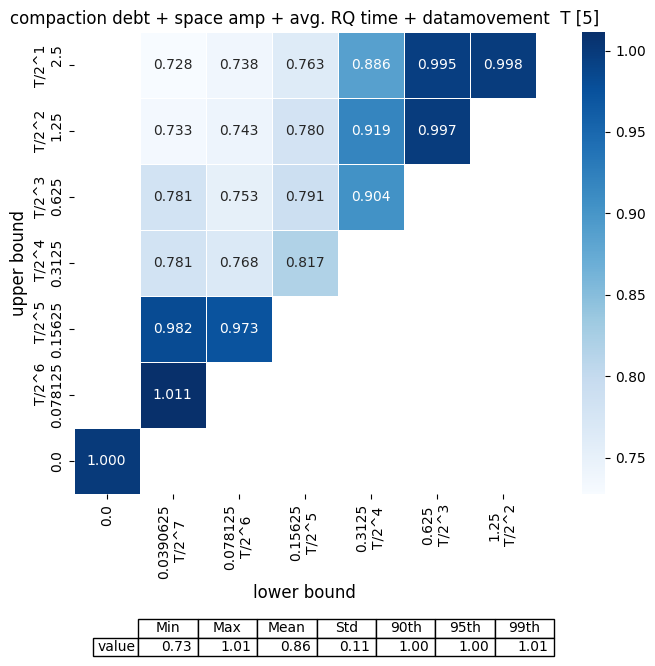

In [22]:
plotheatmaps = PlotHeatMaps(all_stats)

# # plotheatmaps.total_bytes_written()
# plotheatmaps.compaction_debt()
# # plotheatmaps.writeamp_debt()
# plotheatmaps.spaceamp_debt()
# # plotheatmaps.avg_bytes_written_for_range_queries()
# # plotheatmaps.total_bytes_read_compaction()
# # plotheatmaps.avg_bytes_read_range_query()
# plotheatmaps.avg_time_of_range_queries()
# plotheatmaps.overall_data_movement()

plotheatmaps.all_in_one()



In [23]:
def get_bounds(lowest, highest, num_points):
    """Get a list of bounds between the lowest and highest values."""
    points = []

    def find_midpoints(start, end, point):
        if point == 1:
            return [start, end]
        midpoint = (start + end) / 2
        left_point = point // 2
        right_point = point - left_point
        points.append(midpoint)
        find_midpoints(start, midpoint, left_point)
        find_midpoints(midpoint, end, right_point)

    find_midpoints(lowest, highest, num_points)
    return sorted(points) + [highest]

In [24]:
size_ratios = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for size_ratio in size_ratios:
  lower_bounds = get_bounds(0, size_ratio/2, 20)
  upper_bounds = get_bounds(size_ratio/2, size_ratio, 20)

  print("LBs", lower_bounds)
  print("UBs", upper_bounds)
  print()

LBs [0.0625, 0.125, 0.1875, 0.21875, 0.25, 0.3125, 0.375, 0.4375, 0.46875, 0.5, 0.5625, 0.625, 0.6875, 0.71875, 0.75, 0.8125, 0.875, 0.9375, 0.96875, 1.0]
UBs [1.0625, 1.125, 1.1875, 1.21875, 1.25, 1.3125, 1.375, 1.4375, 1.46875, 1.5, 1.5625, 1.625, 1.6875, 1.71875, 1.75, 1.8125, 1.875, 1.9375, 1.96875, 2]

LBs [0.09375, 0.1875, 0.28125, 0.328125, 0.375, 0.46875, 0.5625, 0.65625, 0.703125, 0.75, 0.84375, 0.9375, 1.03125, 1.078125, 1.125, 1.21875, 1.3125, 1.40625, 1.453125, 1.5]
UBs [1.59375, 1.6875, 1.78125, 1.828125, 1.875, 1.96875, 2.0625, 2.15625, 2.203125, 2.25, 2.34375, 2.4375, 2.53125, 2.578125, 2.625, 2.71875, 2.8125, 2.90625, 2.953125, 3]

LBs [0.125, 0.25, 0.375, 0.4375, 0.5, 0.625, 0.75, 0.875, 0.9375, 1.0, 1.125, 1.25, 1.375, 1.4375, 1.5, 1.625, 1.75, 1.875, 1.9375, 2.0]
UBs [2.125, 2.25, 2.375, 2.4375, 2.5, 2.625, 2.75, 2.875, 2.9375, 3.0, 3.125, 3.25, 3.375, 3.4375, 3.5, 3.625, 3.75, 3.875, 3.9375, 4]

LBs [0.15625, 0.3125, 0.46875, 0.546875, 0.625, 0.78125, 0.9375, 1.0937